## Using Neural Nets to make Art!

In this post, I am using a convolutional neural network to make some neat art! This is inspired by Siraj (look him up on youtube!) and his work in this area.

Up until now, art has always been a work of imagination left best with the creatives. Artists have had a unique way of expressing them and the times they lived in through a unique lens, specific to the way they viewed the world around them. Be it the Da Vinci and his wonder inspiring work or Van Gogh and his twisted look at the world, art has always inspired millions through out the generations.

Technology has always inspired artists to push the boundries and explore the possibilitilies beyond what has already been done. The first film camera was not invented as a technology to aid art, but merely a tool to capture reality. Clearly, artists saw it differently giving birth to the entire film and animation industry. This is true for every major tech we have created, artisits have always found a way to use the novel tool creatively. 

With the recent advnces in machine learning, we can generate incredible art pieces within minutes, that may have taken an expert artists years to incomplete just about a century ago. Machine learning creates the possibility of prototyping an art piece atleast a 100x faster while having the medium collaborate with the artist. The beauty herein lies in the fact that this new wave of technological advancement will enhance the way art is created and looked at by upgrading the tools at hand.



### Introduction

Here, I will use python to take any image and turn it into the style of any artist of my choosing. Google released a similar production known as "Deep Dream" in 2015, and the internet took it was throbbing enthusiasm. They essentially trained a Convolutional Neural Net that classifies images and then used an optimization technique to enhance the patterns in the input image as opposed to its own weights based on what the network had learned. Soon after this, the website "Deepart" came out that allowed users to have any image convert to a painting style of their choice within clicks!

### So how does this work?

To understand how this "magic" called the style transfer process works, we will write our own scrpit in Keraswith a TensorFlow backend.  I will use a base image (a photo of my favorite animal) and a style reference image. My script will use Vincent Van Gogh's "Starry night" as the reference and apply it to the base image.
Here we go by first importing the necessary dependancies:


In [52]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave



So we will feed these images into the neural net by first converting them into the de facto format for all neural nets, Tensors. The variable function from keras backend Tensorflow is equivalent to tf.variable. The parameter to this will be the image converted to an array and then we do the same thing for the style image. We then create a combination image that can later store our end results by using a placeholder to initialize it with a given width and height.

Here is the content image:

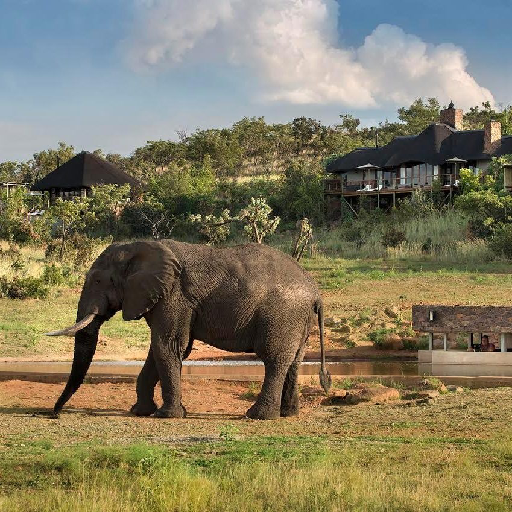

In [35]:
height = 512
width = 512

content_image_path = 'images/elephant.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

Here I load up the style image:

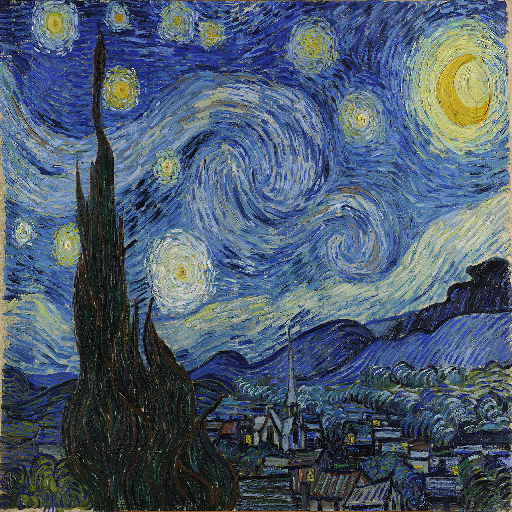

In [36]:
style_image_path = '/Users/vivek/Desktop/VanGogh.jpg'
style_image = Image.open (style_image_path)
style_image = style_image.resize((height, width))
style_image

Nest, we convert both these images so that they are in a suitable form for numerical processing. We add another dimension (beyond the heing, width and normal 3 dimensions) so we can later concatenate the representations of the two images into a common data structure:

In [37]:
content_array = np.asarray(content_image, dtype='float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


We will be using the VGG network moving forward. Keras has wrapped this model really well for us to use easily as we will moving forward.
VGG16 is a 16 layer convolutional net, created by Visual Geometry Group at Oxford that won the ImageNet completition in 2014. The idea here is that a CNN pre-trained for image classification on  thousands of different images already knows how to encode information in a contained image. I has learn features at each layer that can detect certain generalized features. These are the features we will be using to perform style transfer.
We don not need the convolution block at the top of this net because its fully connected layers and softmax function help classify the images by squashing the dimensionality feature map, and outputting a probability. We are not classifying just tranfering. This is essentially an optimization where we have some loss function that measures the error value that we will be attempting to minimize.
Our loss function in this case can be decomposed into two parts: 


1) Content Loss
We initialize the total loss to zero and add each of these to it. First the content loss. An image always has a content component and a style component. We know that the features a CNN learns are arranged in order of progressively more abstract compositions. Since the higher level features are more abstract,  such as detecting faces, we can associate them with content. 
When we run our output image and our reference image through the network, we obtain a set of  feature representations for both from a hidden layer of our choice. We then measure the euclidean distance between them to calculate our loss.

2) Style Loss
This is also a function of our network's hidden layer outputs, but slightly more complex. We still pass both images through the net to observe their activations, but instead of comparing the raw activations directly for content, we add an extra step to measure the correlation between the activations. We take what is refered to as the gram matrix for both the images of the activation at a given layer in the network. This will measure which features tend to activate together. This basically represents the probablity of different features to co occur in different parts of the image. Once we have this we can define this style loss as a euclidean distance between the gram matrices between the reference image and the output image, and compute the total style loss as the weighted sum of the style loss at each layer we choose.

Now that we have the losses we need to define the gradients of the output image with respect to the loss, and then use those gradients to iteratively minimize the loss. 

We now need to massage the input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduced the VGG Network model.

For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [38]:
content_array[:,:,:,0] -= 103.99
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the *combination* image that retains the content of the content image while incorporating the style of the style image.

In [39]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))

We now go ahead and concatenate all this image data into a single tensor that can be used for processing Kera's VGG16 model.

In [40]:
input_tensor = backend.concatenate([content_image,
                                    style_image,
                                    combination_image], axis = 0)

As previously stated, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the part of the model marked in green in the table below.

![VGG Network Architectures](images/vgg-architecture.png "VGG Network Architectures")

It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

In [41]:
import h5py
model = VGG16(input_tensor=input_tensor, weights='imagenet',
              include_top=False)

As is clear from the table above, the model we're working with has a lot of layers. Keras has its own names for these layers. Let's make a list of these names so that we can easily refer to individual layers later.

In [42]:
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers

{'block1_conv1': <tf.Tensor 'block1_conv1_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2_1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool_1/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2_1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool_1/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3_1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool_1/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1_1/Relu:0' shape=(3, 64, 64, 51

We now pick the weights, this can be played around with:

In [43]:
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

In [44]:
loss = backend.variable(0.)

Now the content loss:

In [45]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

loss += content_weight * content_loss(content_image_features,
                                      combination_features)

And the style loss:

In [46]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [47]:
def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

feature_layers = ['block1_conv2', 'block2_conv2',
                  'block3_conv3', 'block4_conv3',
                  'block5_conv3']
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

Finally the total variation loss:

In [48]:
def total_variation_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss += total_variation_weight * total_variation_loss(combination_image)

Now we go ahead and define the needed gradients to solve the optimisation problem:

In [49]:
grads = backend.gradients(loss, combination_image)

We then introduce an Evaluator class that computes loss and gradients in one pass while retrieving them via two separate functions, loss and grads. This is done because scipy.optimize requires separate functions for loss and gradients, but computing them separately would be inefficient.

In [50]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)

def eval_loss_and_grads(x):
    x = x.reshape((1, height, width, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    return loss_value, grad_values

class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the L-BFGS algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.
We stop after 8 iterations because the output looks good to me and the loss stops reducing significantly.

In [53]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

iterations = 8

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    end_time = time.time()
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 5.09879e+10
Iteration 0 completed in 930s
Start of iteration 1
Current loss value: 2.26346e+10
Iteration 1 completed in 975s
Start of iteration 2
Current loss value: 1.69367e+10
Iteration 2 completed in 928s
Start of iteration 3
Current loss value: 1.53517e+10
Iteration 3 completed in 941s
Start of iteration 4
Current loss value: 1.45988e+10
Iteration 4 completed in 869s
Start of iteration 5
Current loss value: 1.42363e+10
Iteration 5 completed in 863s
Start of iteration 6
Current loss value: 1.3977e+10
Iteration 6 completed in 883s
Start of iteration 7
Current loss value: 1.37803e+10
Iteration 7 completed in 880s


If you are working on a laptop like me, go grab a nice meal because this will take a while. Here is the output from the last iteration though!

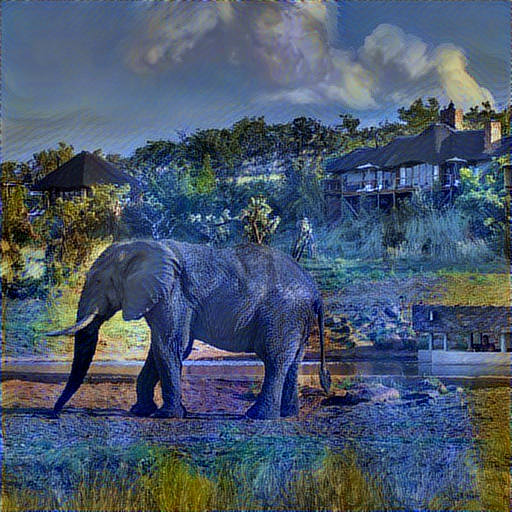

In [54]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

Neat! We can continue playing with this by changing the two images, their size, the weights of our loss functions, etc.
It is important to remember that running this for just 8 iterations took my macbook air about 4 hours. This is a very CPU intensive process, and so when scaled this is a relatively expensive problem to work with. 

Thanks for reading!